# Try a reverse GAN for MNIST

In [1]:
#Import a ton of stuff
import os
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

from keras.utils.generic_utils import Progbar

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 6021)
/home/henry/.local/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:631: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn(warn)


In [2]:
# Load the MNIST CSV data from https://pjreddie.com/projects/mnist-in-csv/
data_train = np.genfromtxt('./MNIST_Data/mnist_train.csv', delimiter = ',')
data_test = np.genfromtxt('./MNIST_Data/mnist_test.csv', delimiter = ',')
print(data_train.shape, data_test.shape)

(60000, 785) (10000, 785)


In [3]:
# Now reformat it into the format we want
# NOTE: PyTorch is weird so if we wanted to use cross entropy we need to keep them as logits, but we won't so...
x_train = np.reshape(data_train[:, 1:], (-1, 1, 28, 28))
#y_train = data_train[:, 0]
y_train = np.zeros((data_train.shape[0], 10), dtype = np.uint8)
y_train[np.arange(data_train.shape[0]), data_train[:, 0].astype(int)] = 1

x_test = np.reshape(data_test[:, 1:], (-1, 1, 28, 28))
#y_test = data_test[:, 0]
y_test = np.zeros((data_test.shape[0], 10), dtype = np.uint8)
y_test[np.arange(data_test.shape[0]), data_test[:, 0].astype(int)] = 1

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Looks like we can convert our x to unint8
# We'll convert back to float and rescale to between 0 and 1 on the GPU batchwise to save CPU RAM
print(np.unique(x_train))
x_train = x_train.astype(np.uint8)
x_test = x_test.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

(60000, 1, 28, 28) (60000, 10)
(10000, 1, 28, 28) (10000, 10)
[   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.
   36.   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.
   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.
   60.   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.
   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.
   84.   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.
   96.   97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.
  108.  109.  110.  111.  112.  113.  114.  115.  116.  117.  118.  119.
  120.  121.  122.  123.  124.  125.  126.  127.  128.  129.  130.  131.
  132.  133.  134.  135.  136.  137.  138.  139.  140.  141.  142.  143.
  144.  145.  146.  147.  148.  149.  150.  151.  152.  153.  

[0 0 0 0 0 0 0 1 0 0]


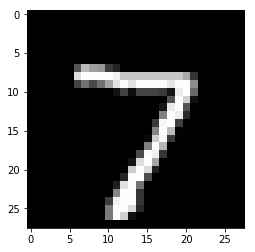

In [4]:
# Show an example from the test set
plt.figure(0)
plt.imshow(x_test[0, 0], cmap = 'gray')
print(y_test[0])

# OK, before we actually build this model, I wanna to know, how the hell does pytorch's set of classification functions work?

In [5]:
# Experiment with pytorch's activation functions
v = Variable(torch.Tensor([0, 1, 0]))
v_np = np.array([0, 1, 0])
print(F.log_softmax(v))
print(v_np - np.log(np.sum(np.exp(v_np))))

Variable containing:
-1.5514
-0.5514
-1.5514
[torch.FloatTensor of size 3]

[-1.55144471 -0.55144471 -1.55144471]


## OK, so log_softmax works as we expect -> $f(x) = log(\frac{e^x_i}{\sum_{j} e^x_j}) = x_i - log(\sum_{j} e^x_j)$ Although this is basically the negative log loss as we're already taking logs of the output
## Now let's try cross_entropy

In [6]:
u = Variable(torch.Tensor([0.25, 0.5, 0.25])).view(1, 3)
v = Variable(torch.LongTensor([1]))
u_np = np.array([0.25, 0.5, 0.25])
v_np = 1.0
print(v, u)
print(F.cross_entropy(u, v))
w_np = u_np - np.log(np.sum(np.exp(u_np)))
print(w_np)
print(np.log(u_np))

Variable containing:
 1
[torch.LongTensor of size 1]
 Variable containing:
 0.2500  0.5000  0.2500
[torch.FloatTensor of size 1x3]

Variable containing:
 0.9391
[torch.FloatTensor of size 1]

[-1.18906993 -0.93906993 -1.18906993]
[-1.38629436 -0.69314718 -1.38629436]


## OK, so cross entropy is basically negative of log_softmax indexed by targets
## However, note that cross entropy in PyTorch is NOT the same as cross entropy in common ML literature (i.e. $-t * log(x)$)

## Now that my curiousity has been satisfied, let's build this reverse GAN! First we build the conditional GAN

In [7]:
# Now let's start building the GAN
# But first, we're going to redefine Conv2D and Linear with our own initialisations
# We're going to use Glorot (aka Xavier) uniform init for all weights
# And we will use zero init for all biases
class Conv2d(nn.Conv2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Linear(nn.Linear):
    def reset_parameters(self):
        stdv = np.sqrt(6 / (self.in_features + self.out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.fc1 = Linear(128, 256)
        self.fc2 = Linear(256, 512)
        self.fc1_c = Linear(10, 256)
        self.fc2_c = Linear(256, 512)
        self.fc1_all = Linear(512, 512)

        self.conv1 = Conv2d(8, 16, kernel_size = 5, padding = 2) # 8 x 8 x 8 -> 16 x 16 x 16
        self.conv2 = Conv2d(16, 32, kernel_size = 5, padding = 2) # 16 x 16 x 16 -> 32 x 32 x 32
        self.conv3 = Conv2d(32, 1, kernel_size = 5) # 32 x 32 x 32 -> 1 x 28 x 28

    def forward(self, x, x_c):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))

        x_c = F.elu(self.fc1_c(x_c))
        x_c = F.elu(self.fc2_c(x_c))
        x = x_c + x
        x = F.elu(self.fc1_all(x)).view(-1, 8, 8, 8)

        x = F.upsample(x, scale_factor = 2, mode = 'nearest')
        x = F.elu(self.conv1(x))
        x = F.upsample(x, scale_factor = 2, mode = 'nearest')
        x = F.elu(self.conv2(x))

        return F.relu(self.conv3(x))

class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()

        self.conv1 = Conv2d(1, 16, kernel_size = 5) # 1 x 28 x 28 -> 16 x 12 x 12
        self.conv2 = Conv2d(16, 32, kernel_size = 5) # 16 x 12 x 12 -> 32 x 4 x 4

        self.fc1 = Linear(512, 256)
        self.fc2 = Linear(256, 1)

        self.fc1_c = Linear(10, 256)
        self.fc2_c = Linear(256, 512)

    def forward(self, x, x_c):
        x = F.max_pool2d(F.elu(self.conv1(x)), 2)
        x = F.max_pool2d(F.elu(self.conv2(x)), 2).view(-1, 512)

        x_c = F.elu(self.fc1_c(x_c))
        x_c = F.elu(self.fc2_c(x_c))
        x = x_c + x

        x = F.elu(self.fc1(x))
        return F.sigmoid(self.fc2(x))

In [8]:
# OK, now we create the actual models
generator = G().cuda()
discriminator = D().cuda()

In [9]:
# Prep the data by turning them into tensors and putting them into a PyTorch dataloader
train_tensors = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_tensors = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
train_loader = DataLoader(train_tensors, batch_size = 256, shuffle = True, num_workers = 6, pin_memory = True)
test_loader = DataLoader(test_tensors, batch_size = 256, shuffle = True, num_workers = 6, pin_memory = True)

In [10]:
# Create the optimisers
g_optim = optim.Adam(generator.parameters(), lr=1e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=1e-4)
loss = nn.BCELoss().cuda()

Start training
100/100 [==============================] - 832s - error_real: 0.5141 - error_fake: 0.3928 - error_g: 1.4375   


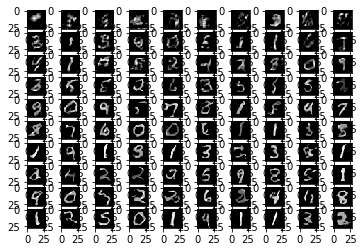

In [11]:
# Alright, everything's setup, let's run the GAN and train it first
pb = Progbar(100)
print('Start training')
for epoch in range(100):
    for i, (data, targets) in enumerate(train_loader, 0):
        ones = Variable(torch.ones(data.size()[0], 1)).cuda()
        zeros = Variable(torch.zeros(data.size()[0], 1)).cuda()

        # Train the discriminator
        # Max log(D(x)) + log(1 - D(G(z)))
        discriminator.zero_grad()

        # Forward & backward pass with real data
        real = Variable(data.float().cuda(async = True) / 255.0)
        condition = Variable(targets.float().cuda(async = True))
        out_real = discriminator(real, condition)
        error_real = loss(out_real, ones)
        error_real.backward()

        # Forward pass with fake data
        fake = generator(Variable(torch.randn(data.size()[0], 128)).cuda(), condition)
        out_fake = discriminator(fake.detach(), condition.detach())
        error_fake = loss(out_fake, zeros)
        error_fake.backward()
        d_optim.step()

        # Train the generator
        generator.zero_grad()

        # Now we just do the backward pass with fake data as we already did the forward pass
        out_fake = discriminator(fake, condition)
        error_g = loss(out_fake, ones)
        error_g.backward()
        g_optim.step()
    pb.update(epoch + 1, [('error_real', error_real.cpu().data.numpy()),
                      ('error_fake', error_fake.cpu().data.numpy()),
                      ('error_g', error_g.cpu().data.numpy())])
    plt.subplot(10, 10, epoch + 1)
    plt.imshow(np.round(fake.cpu().data.numpy()[0, 0] * 255), cmap = 'gray')

In [12]:
torch.save(generator.state_dict(), 'mnist_g.torch')
torch.save(discriminator.state_dict(), 'mnist_d.torch')

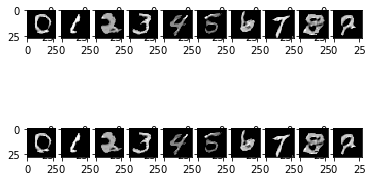

In [25]:
generator.load_state_dict(torch.load('mnist_g.torch'))
discriminator.load_state_dict(torch.load('mnist_d.torch'))

plt.figure(1)
fake = []
for i in range(2):
    for j in range(10):
        plt.subplot(2, 10, i * 10 + j + 1)
        fake += [generator(Variable(torch.randn(1, 128)).cuda(), Variable(torch.eye(10)[j:j + 1]).cuda())]
        plt.imshow(np.round(fake[-1].cpu().data.numpy()[0, 0] * 255), cmap = 'gray')
    